# This notebook we will compare the binding pattern in different RBPs

In [1]:
import sys
sys.path.append('/home/hsher/projects/Metadensity')
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt


# Load encode metadata
I have precompiled list of uID and the .bam, .bigWig files in the following dataframe.

In [2]:
# load IDs
encode_data = pd.read_pickle('~/projects/eclip_encode_id.pickle')
eclip_bam = pd.read_csv('/home/hsher/projects/RBP_annot/ENCODE_FINAL_ANNOTATIONS.uidsonly.txt.manifesthg38.txt', sep = '\t', header= 0)

# join data
encode_data = pd.merge(eclip_bam[['uID', 'RBP', 'Cell line']], encode_data, left_on = ['RBP', 'Cell line'], right_on = ['RBP', 'cell_line'])

`minus_0` is the bigWig file for `minus` strand for replicate `0`. The files are in `/home/hsher/seqdata/eclip_raw`. You don't need to specify all of them. The eCLIP object will take care of them.

# load RBPs into eCLIP object

I build an eCLIP object that will connect all .bam, .bigWig and .bed (for IDR peaks, individual peaks) together. All you need to do is point a row of the previous dataframe, and use `RBP_centric_approach()` to compute the regions for metagene, and find positive (transcripts with IDR) and negative (transcript w/o any peaks) examples. Building the object will take a while (~1 min) since a lot of I/O.

In [3]:
HNRNPC = eCLIP()
HNRNPC.RBP_centric_approach(encode_data.loc[(encode_data['RBP'] == 'HNRNPC')&(encode_data['Cell line'] == 'HepG2')])

finding negative/positive examples


In [4]:
RPS3 = eCLIP()
RPS3.RBP_centric_approach(encode_data.loc[(encode_data['RBP'] == 'RPS3')&(encode_data['Cell line'] == 'HepG2')])

finding negative/positive examples


In [5]:
RBFOX2 = eCLIP()
RBFOX2.RBP_centric_approach(encode_data.loc[(encode_data['RBP'] == 'RBFOX2')&(encode_data['Cell line'] == 'HepG2')])

finding negative/positive examples


In [6]:
LIN28B = eCLIP()
LIN28B.RBP_centric_approach(encode_data.loc[(encode_data['RBP'] == 'LIN28B')&(encode_data['Cell line'] == 'HepG2')])

finding negative/positive examples


# Calulcate Density and Truncation sites
Object `Metatruncation` and `Metadensity` takes three things:
1. an experiment object `eCLIP` or `STAMP`.
2. a set of transcript pyBedTools that you want to plot on
3. name of the object

Options include:
1. `sample_no=` allows you to decide how many transcript you want to build the density. It will take longer. By default, `sample_no=200`. So in transcript if you give more than 200 transcripts, only 200 will be used
2. `metagene` allows you to use pre-built metagene. This feature is more useful when you want to compare the same set of RNA over many RBPs.
3. `background_method` handles how you want to deal with IP v.s. Input
4. `normalize` handles how you want to normalize values within a transcript.

## Difference between truncation and density

`Metadensity` represents read coverage. `Metatruncation` represents the 5' end of read 2 for `eCLIP`; edit sites for `STAMP`.

In [7]:
# here for the set of transcript, we use the IDR peak containing transcript assuming they have good signal
def build_idr_metadensity(eCLIP):
    ''' build metadensity object for eCLIP and its idr peak containing transcript'''
    m = Metadensity(eCLIP, eCLIP.idr_transcript, eCLIP.name+'_idr',background_method = 'subtract', normalize = True)
    m.get_density_array()
    return m
def build_idr_metatruncate(eCLIP):
    ''' build metadensity object for eCLIP and its idr peak containing transcript'''
    m = Metatruncate(eCLIP, eCLIP.idr_transcript, eCLIP.name+'_idr',background_method = 'subtract', normalize = True)
    m.get_density_array(use_truncation = True)
    return m

In [8]:
# this step takes some time for building metagene from the annotation files.
HNRNPC_den = build_idr_metadensity(HNRNPC)
RPS3_den = build_idr_metadensity(RPS3)
RBFOX2_den = build_idr_metadensity(RBFOX2)
LIN28B_den = build_idr_metadensity(LIN28B)

HNRNPC_trun = build_idr_metatruncate(HNRNPC)
RPS3_trun = build_idr_metatruncate(RPS3)
RBFOX2_trun = build_idr_metatruncate(RBFOX2)
LIN28B_trun = build_idr_metatruncate(LIN28B)

Done Building Metagene
Done Building Metagene
Done Building Metagene
Done Building Metagene
Done Building Metagene
Done Building Metagene
Done Building Metagene
Done Building Metagene


# Visualize RBP map: individual density per transcript

In [9]:
%load_ext autoreload

%autoreload 2
from metadensity.plotd import *

/home/hsher/projects/Metadensity/metadensity/plotd.py:148: RuntimeWarning: Mean of empty slice
  density_concat = np.nanmean(np.stack([den_arr[feat,align, r] for r in m.eCLIP.rep_keys]), axis = 0)


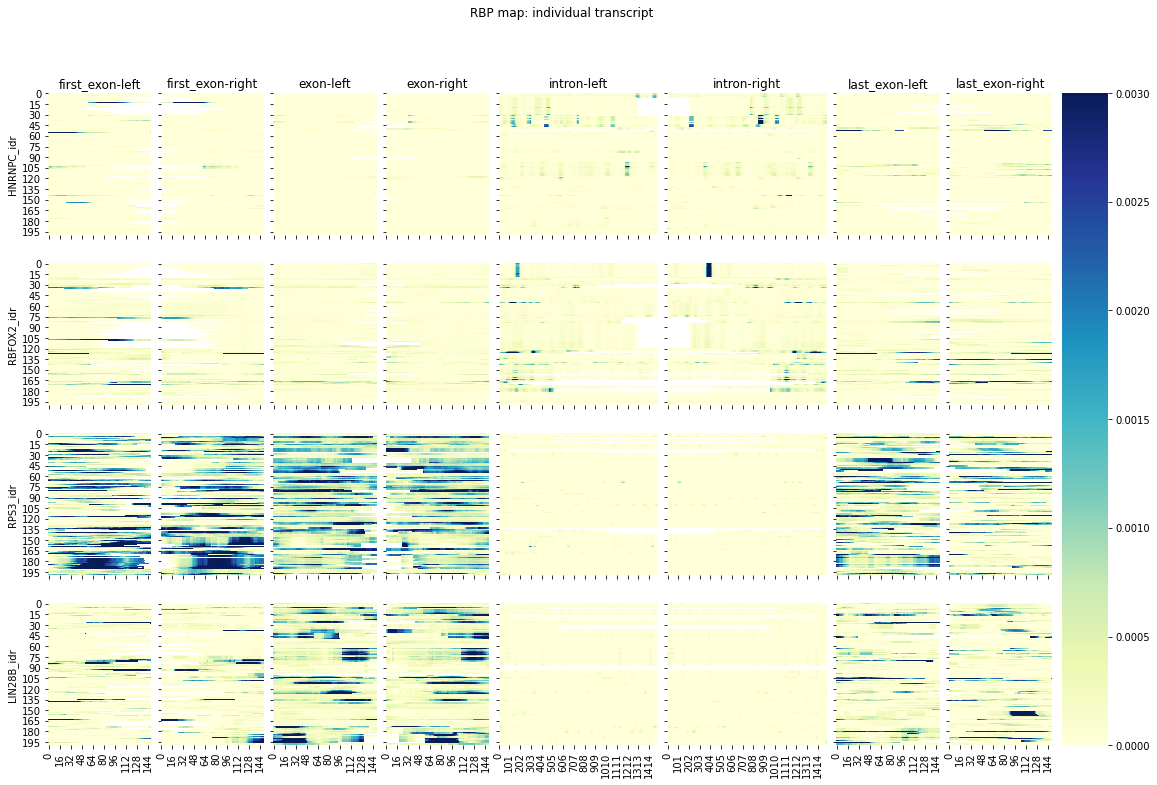

In [10]:
### PLOT INDIVIDUAL DENSITY
# you can customize the list of features you want to show. This is suitable when you are looking for splicing
generic_RNA = ['first_exon', 'exon', 'intron', 'last_exon']
plot_rbp_map([HNRNPC_den,  RBFOX2_den, RPS3_den,LIN28B_den], features_to_show = generic_RNA)

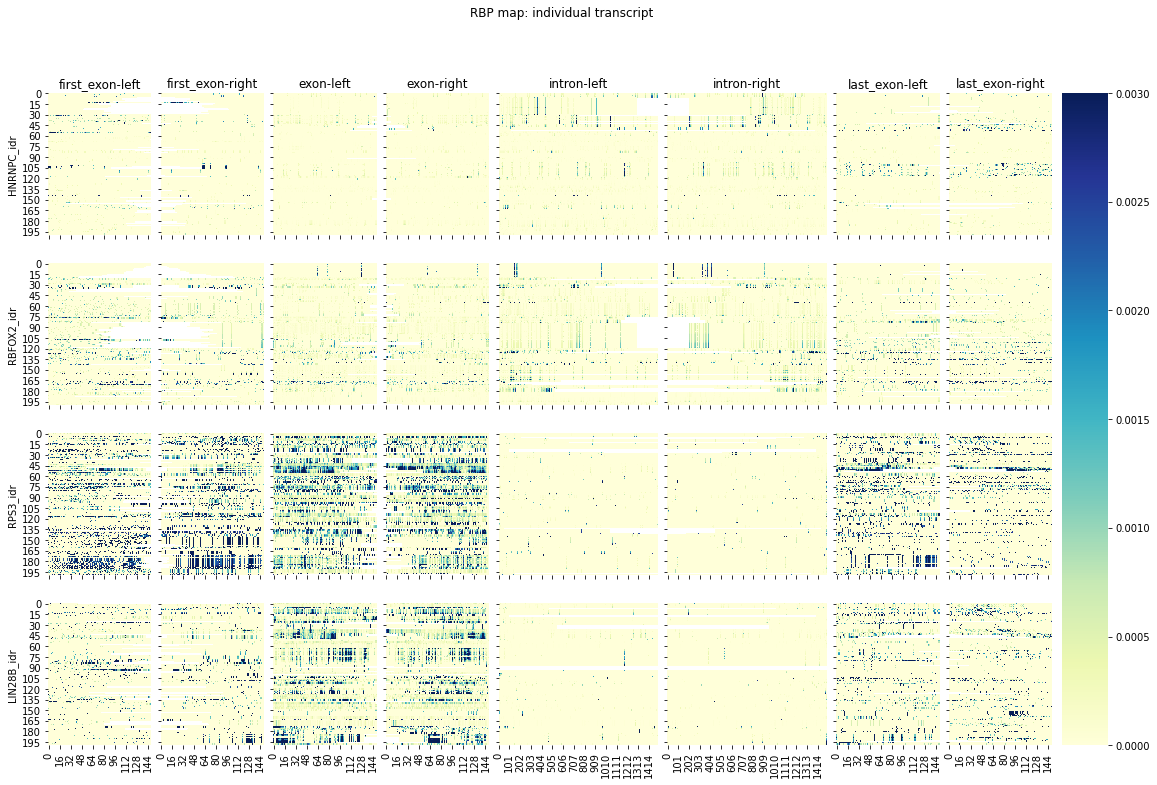

In [11]:
### PLOT INDIVIDUAL TRUNCATION SITES

plot_rbp_map([HNRNPC_trun,  RBFOX2_trun, RPS3_trun,LIN28B_trun], features_to_show = generic_RNA)

# Median and Mean density

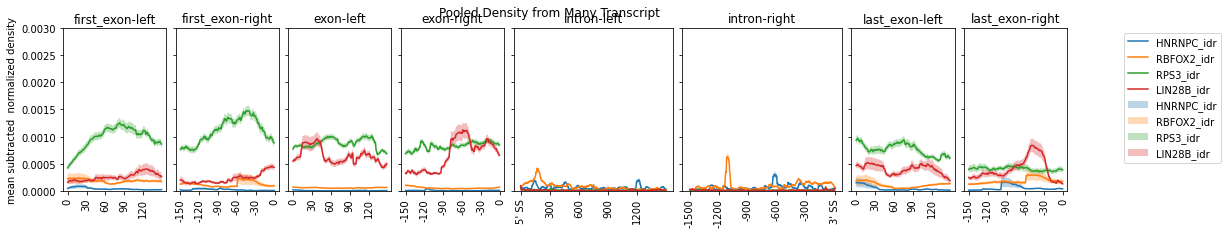

In [12]:
plot_mean_density([HNRNPC_den, RBFOX2_den, RPS3_den, LIN28B_den], features_to_show = generic_RNA, ymax = 0.003)

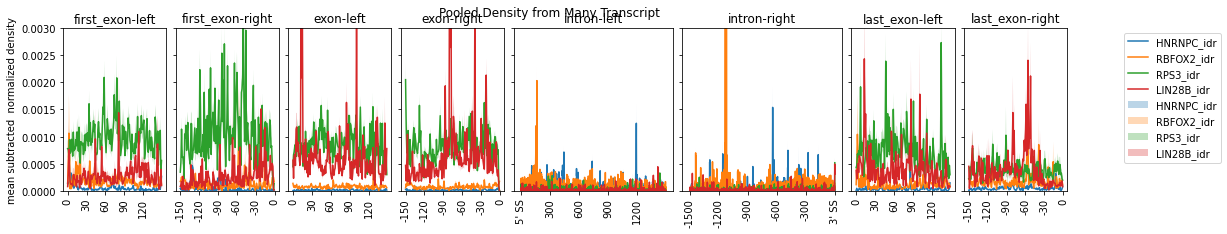

In [13]:
plot_mean_density([HNRNPC_trun, RBFOX2_trun, RPS3_trun, LIN28B_trun], features_to_show = generic_RNA, ymax = 0.003)

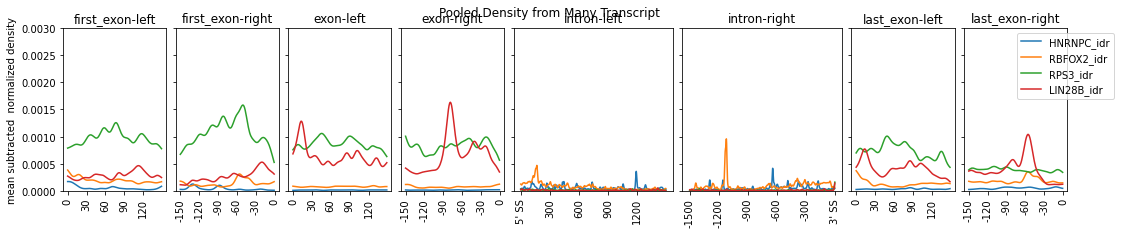

In [14]:
# you can smooth if you find spiky truncation density ugly :-\
plot_mean_density([HNRNPC_trun, RBFOX2_trun, RPS3_trun, LIN28B_trun], features_to_show = generic_RNA, ymax = 0.003, smooth = True)

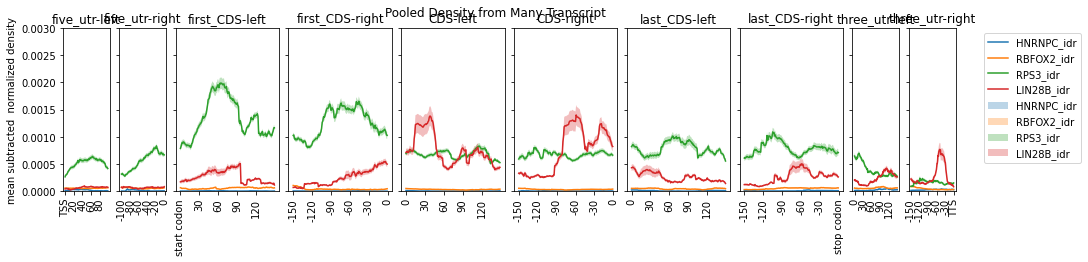

In [15]:
protein_coding = ['five_utr', 'first_CDS', 'CDS', 'last_CDS', 'three_utr']
plot_mean_density([HNRNPC_den, RBFOX2_den, RPS3_den, LIN28B_den], features_to_show = protein_coding)

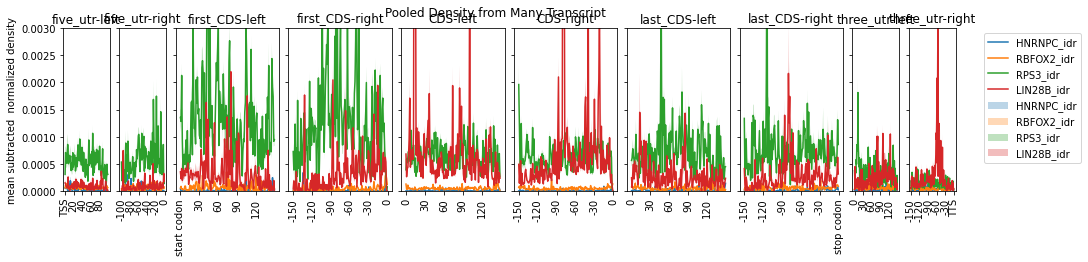

In [16]:
protein_coding = ['five_utr', 'first_CDS', 'CDS', 'last_CDS', 'three_utr']
plot_mean_density([HNRNPC_trun, RBFOX2_trun, RPS3_trun, LIN28B_trun], features_to_show = protein_coding)

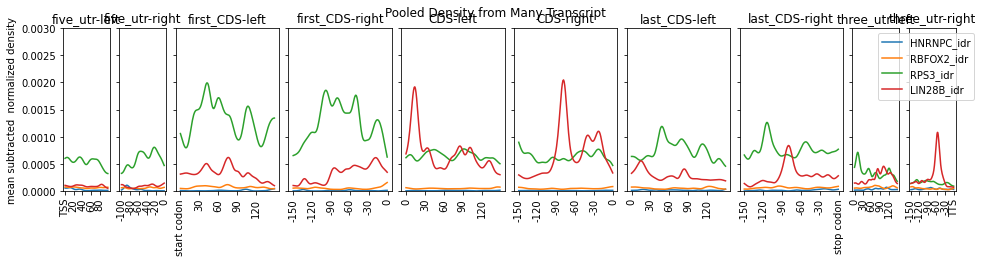

In [17]:
protein_coding = ['five_utr', 'first_CDS', 'CDS', 'last_CDS', 'three_utr']
plot_mean_density([HNRNPC_trun, RBFOX2_trun, RPS3_trun, LIN28B_trun], features_to_show = protein_coding, smooth = True)